In [1]:
# 데이터 핸들링 및 확인을 위한 라이브러리
import pandas as pd
import os
import cv2
import numpy as np
from PIL import Image 
import glob
import random

import matplotlib
import matplotlib.pyplot as plt

# 사이킷런 라이브러리와 모듈
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

# 케라스 라이브러리와 모듈
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

# 텐서플로우 라이브러리와 모듈
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# W&B 라이브러리
!pip install wandb==0.16.0
import wandb
from wandb.keras import WandbCallback

In [2]:
def load_data(data_directory):
    images = []
    labels = []
    classes = []
    label_encoder = LabelEncoder()

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name) # 각 클래스 디렉터리 경로
        if os.path.isdir(class_path): # 디렉터리인 경우만 취급
            classes.append(class_name) # 클래스 리스트

            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename) # 각각의 이미지 파일 경로
                img = cv2.imread(filepath) # 각각의 이미지 파일 로드
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환
                    img = cv2.resize(img, (224, 224)) # 224X224 사이즈로 변환
                    img = img / 255.0 # 픽셀값이 0에서 1사이가 되도록 정규화
                    images.append(img)
                    labels.append(class_name)
    images = np.array(images)
    labels = label_encoder.fit_transform(labels) # 라벨 생성

    return images, labels, classes

data_dir = os.getenv('HOME') + '/aiffel/DL_Thon/jellyfish/Train_Test_Valid' # 데이터 부모 디렉터리 경로
# 훈련 데이터셋 로드
train_dir = os.path.join(data_dir, 'Train')
train_images, train_labels, train_classes = load_data(train_dir)

# 검증 데이터셋 로드
valid_dir = os.path.join(data_dir, 'valid')
valid_images, valid_labels, valid_classes = load_data(valid_dir)

# 테스트 데이터셋 로드
test_dir = os.path.join(data_dir, 'test')
test_images, test_labels, test_classes = load_data(test_dir)

* 이미지 데이터가 저장되어 있는 경로에 접근하여 이미지를 로드한다.  
* 로드한 이미지의 색상표, 크기 등을 학습에 용이하도록 변환한다.
* 각 이미지가 저장되어 있는 디렉터리를 구분하여 레이블을 지정한다.

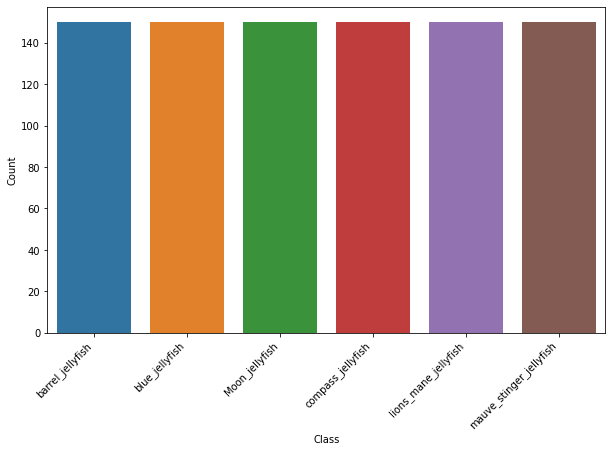

In [3]:
# 각 클래스 별 데이터 개수 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x=[train_classes[label] for label in train_labels])  
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [4]:
# 각각의 데이터 형태 확인
print(f'훈련 데이터: {train_images.shape}, 훈련 데이터 라벨: {train_labels.shape}')
print(f'검증 데이터: {valid_images.shape}, 검증 데이터 라벨: {valid_labels.shape}')
print(f'평가 데이터: {test_images.shape}, 평가 데이터 라벨: {test_labels.shape}')

훈련 데이터: (900, 224, 224, 3), 훈련 데이터 라벨: (900,)
검증 데이터: (39, 224, 224, 3), 검증 데이터 라벨: (39,)
평가 데이터: (40, 224, 224, 3), 평가 데이터 라벨: (40,)


* 이미지 데이터의 개수를 시각화하여 각각의 클래스 별 데이터 수의 차이를 확인한다.
* train의 이미지 데이터와 레이블 데이터의 형태를 확인한다. 

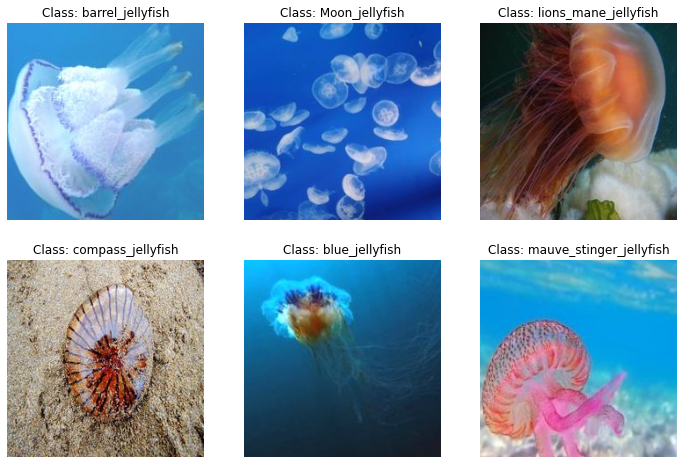

In [6]:
import random

base_dir = train_dir
class_names = train_classes

def visualize_random_images(base_dir, class_names, num_images=6):
    plt.figure(figsize=(12, 8))
    
    available_classes = []  # 적어도 하나의 이미지가 있는 클래스들
    for i, class_nm in enumerate(class_names):
        class_name = class_nm
        class_dir = os.path.join(base_dir, class_name)
        if os.path.exists(class_dir) and os.listdir(class_dir):  # 폴더가 존재하고 비어있지 않은 경우
            available_classes.append(class_name)
    
    if len(available_classes) < num_images:
        print("Not enough classes with images to visualize.")
        return

    for i, class_name in enumerate(random.sample(available_classes, num_images)):
        class_dir = os.path.join(base_dir, class_name)
        image_file = random.choice(os.listdir(class_dir))
        image_path = os.path.join(class_dir, image_file)

        image = Image.open(image_path)
        
        plt.subplot(2, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Class: {class_name}")
        plt.axis("off")

    plt.show()

visualize_random_images(base_dir, class_names)

* 각각의 클래스 별로 어떤 이미지가 들어있는지 샘플링하여 확인한다.

In [7]:
wandb.login(key = '5d26d9248c523ede72519a36ef28de222a48d0fc') # wandb 로그인

experiment_name = "CNN-BaseModel-V1-adam-100-0.001-sjlee" # 실험 이름 설정
team_name = "3like4" # 팀 이름 설정
wandb.init(
    project= "Jellyfish_project",
    entity = team_name,
    name=experiment_name,
)

wandb: Currently logged in as: thetjswo (3like4). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


* W&B에 로그인한 후, 실험 이름과 팀 이름, 프로젝트 이름을 지정한다.

In [8]:
def base_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))

    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(6, activation='softmax'))

    return model


model = base_model()
model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      1

* 성능이 좋게 나온 CNN 모델의 구조로 base model을 설계한다.

In [11]:
# 데이터 제너레이터 정의
datagen_train = ImageDataGenerator(
    rotation_range=30, # 이미지 30도 회전
    width_shift_range=0.2, # 가로로 최대 10%까지 이동
    height_shift_range=0.2, # 세로로 최대 10%까지 이동
    shear_range=0.1, # 레이어 변형
    zoom_range=0.3, # 30% 범위로 확대 또는 축소
    horizontal_flip=True, # 수직 반전
    vertical_flip=True, # 수평 반전
)

datagen = ImageDataGenerator()

# 이미지 데이터 증강을 위한 데이터 제너레이터 생성
train_datagen = datagen_train.flow(train_images, train_labels, batch_size=20)
val_datagen = datagen.flow(valid_images, valid_labels, batch_size=20)

# 조기 종료 조건 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_datagen, epochs=150, validation_data=val_datagen, callbacks=[early_stopping])

# WandB에 로깅 정보 전송
wandb.log({"train_loss": history.history['loss'], "val_loss": history.history['val_loss'],
           "train_accuracy": history.history['accuracy'], "val_accuracy": history.history['val_accuracy']})
wandb.finish()

Epoch 1/150
45/45 [==============================] - 14s 217ms/step - loss: 2.2441 - accuracy: 0.2122 - val_loss: 1.7188 - val_accuracy: 0.2564
Epoch 2/150
45/45 [==============================] - 9s 205ms/step - loss: 1.6193 - accuracy: 0.3178 - val_loss: 1.5878 - val_accuracy: 0.3846
Epoch 3/150
45/45 [==============================] - 9s 202ms/step - loss: 1.4681 - accuracy: 0.3578 - val_loss: 1.3631 - val_accuracy: 0.4359
Epoch 4/150
45/45 [==============================] - 9s 204ms/step - loss: 1.3287 - accuracy: 0.4411 - val_loss: 1.3058 - val_accuracy: 0.4359
Epoch 5/150
45/45 [==============================] - 9s 204ms/step - loss: 1.2560 - accuracy: 0.5089 - val_loss: 1.4017 - val_accuracy: 0.3846
Epoch 6/150
45/45 [==============================] - 9s 206ms/step - loss: 1.2567 - accuracy: 0.4944 - val_loss: 1.3817 - val_accuracy: 0.5128
Epoch 7/150
45/45 [==============================] - 9s 205ms/step - loss: 1.1856 - accuracy: 0.5344 - val_loss: 1.2935 - val_accuracy: 0.487

* 데이터의 개수가 많지 않으니, ImageDataGenerator로 이미지를 증강시킨다.
* 조기 종료 콜백을 걸어 검증 손실값이 10회동안 유의미한 변화가 없을 경우 학습을 종료 시킨다.
* 에폭이 진행되는 과정의 학습 정확도, 학습 손실값, 검증 정확도, 검증 손실값을 W&B에 로깅한다.

In [12]:
def visualize_result(history):
    sns.set(style="whitegrid")

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    
    plt.figure(figsize=(12, 6))

    # Accuracy 그래프
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs_range, y=acc, label='Train Accuracy', color='blue')
    sns.lineplot(x=epochs_range, y=val_acc, label='Val Accuracy', color='red')
    plt.title('Train & Val Accuracy')
    plt.legend()

    # Loss 그래프
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs_range, y=loss, label='Train Loss', color='blue')
    sns.lineplot(x=epochs_range, y=val_loss, label='Val Loss', color='red')
    plt.title('Train & Validation Loss')
    plt.legend()

    plt.show()

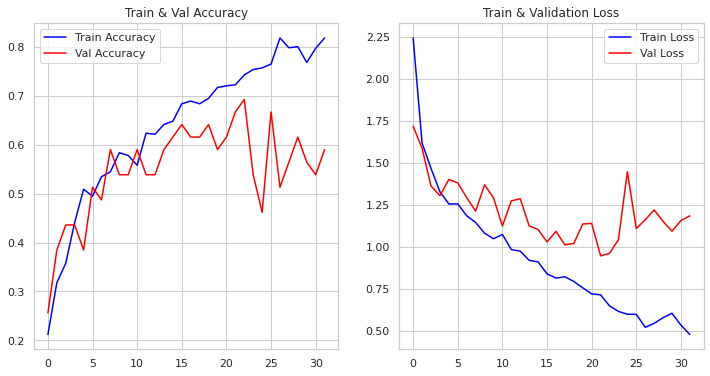

In [13]:
# 학습 결과를 시각화
visualize_result(history)

In [14]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

best_epoch = val_accuracy.index(max(val_accuracy)) + 1

print(f"Best Accuracy: {accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")
print(f"Best Validation Accuracy: {val_accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")

model.save(f"best_model_epoch_{best_epoch}.h5")

Best Accuracy: 0.7422 at Epoch 23
Best Validation Accuracy: 0.6923 at Epoch 23


* 최고 성능을 보일 때는 23번째 에폭이며, 그 때의 정확도는 69.23%이다.

In [17]:
test_datagen = datagen.flow(test_images, test_labels, batch_size=20)
# 테스트 데이터 또는 검증 데이터에 대한 평가
results = model.evaluate(test_datagen)

# 결과 출력
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

2/2 [==============================] - 0s 17ms/step - loss: 1.2741 - accuracy: 0.5500
Test Loss: 1.2741419076919556
Test Accuracy: 0.550000011920929


* 테스트 결과 손실값 1.27, 정확도 55%가 나왔다.

In [15]:
sweep_config = {
    "name": "CNN_V1-adam-20-0.001-gabe",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

def train():
    default_config = {
        "input" : (224, 224, 3),
        "num_classes" : 6,
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config=default_config)
    config = wandb.config


    # 모델 생성 및 컴파일
    model = base_model()
    model.compile(optimizer=config.optimizer,
                  loss=config.loss,
                  metrics=config.metrics)

    # 모델 학습
    model.fit(train_datagen, 
              epochs=config.epoch,
              validation_data=val_datagen,
              callbacks=[WandbCallback()])

    # 모델 평가
    test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

    # 결과 로깅
    wandb.log({"Test Accuracy": test_accuracy, "Test Loss": test_loss})

    
sweep_id = wandb.sweep(sweep_config,
                       entity = "3like4",
                       project = "Jellyfish_project")

wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: owb7hz7u
Sweep URL: https://wandb.ai/3like4/Jellyfish_project/sweeps/owb7hz7u


wandb: Agent Starting Run: 783f9bf5 with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.08263216150769824


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/6
45/45 [==============================] - 10s 211ms/step - loss: 2.1950 - accuracy: 0.1900 - val_loss: 1.7133 - val_accuracy: 0.2051
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_035627-783f9bf5/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_035627-783f9bf5/files/model-best)... Done. 5.0s


Epoch 2/6
45/45 [==============================] - 10s 212ms/step - loss: 1.6368 - accuracy: 0.3089 - val_loss: 1.5002 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_035627-783f9bf5/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_035627-783f9bf5/files/model-best)... Done. 3.7s


Epoch 3/6
45/45 [==============================] - 9s 207ms/step - loss: 1.4994 - accuracy: 0.3589 - val_loss: 1.4143 - val_accuracy: 0.4103 loss: 1.5013 - accuracy
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_035627-783f9bf5/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_035627-783f9bf5/files/model-best)... Done. 4.6s


Epoch 4/6
45/45 [==============================] - 10s 217ms/step - loss: 1.3931 - accuracy: 0.4278 - val_loss: 1.3671 - val_accuracy: 0.4103
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_035627-783f9bf5/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_035627-783f9bf5/files/model-best)... Done. 5.7s


Epoch 5/6
45/45 [==============================] - 10s 213ms/step - loss: 1.3453 - accuracy: 0.4356 - val_loss: 1.3988 - val_accuracy: 0.4615
Epoch 6/6
45/45 [==============================] - 9s 205ms/step - loss: 1.2594 - accuracy: 0.5122 - val_loss: 1.2729 - val_accuracy: 0.5641
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_035627-783f9bf5/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_035627-783f9bf5/files/model-best)... Done. 3.6s


2/2 - 1s - loss: 1.1589 - accuracy: 0.5500


Test Accuracy,▁
Test Loss,▁
accuracy,▁▄▅▆▆█
epoch,▁▂▄▅▇█
loss,█▄▃▂▂▁
val_accuracy,▁▃▅▅▆█
val_loss,█▅▃▂▃▁
Test Accuracy,0.55
Test Loss,1.15893
accuracy,0.51222
best_epoch,5


wandb: Agent Starting Run: tpdqgcp4 with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.04160824444273432


Epoch 1/7
45/45 [==============================] - 10s 204ms/step - loss: 2.5192 - accuracy: 0.2144 - val_loss: 1.6374 - val_accuracy: 0.3590
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_035835-tpdqgcp4/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_035835-tpdqgcp4/files/model-best)... Done. 5.6s


Epoch 2/7
45/45 [==============================] - 10s 217ms/step - loss: 1.6073 - accuracy: 0.3311 - val_loss: 1.5093 - val_accuracy: 0.3590
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_035835-tpdqgcp4/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_035835-tpdqgcp4/files/model-best)... Done. 3.8s


Epoch 3/7
45/45 [==============================] - 10s 214ms/step - loss: 1.5105 - accuracy: 0.3889 - val_loss: 1.4761 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_035835-tpdqgcp4/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_035835-tpdqgcp4/files/model-best)... Done. 3.8s


Epoch 4/7
45/45 [==============================] - 10s 213ms/step - loss: 1.3834 - accuracy: 0.4489 - val_loss: 1.4374 - val_accuracy: 0.4103ss: 1.3834 - accuracy: 0.44
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_035835-tpdqgcp4/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_035835-tpdqgcp4/files/model-best)... Done. 4.5s


Epoch 5/7
45/45 [==============================] - 10s 214ms/step - loss: 1.3474 - accuracy: 0.4800 - val_loss: 1.3038 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_035835-tpdqgcp4/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_035835-tpdqgcp4/files/model-best)... Done. 8.9s


Epoch 6/7
45/45 [==============================] - 10s 217ms/step - loss: 1.2778 - accuracy: 0.4978 - val_loss: 1.3565 - val_accuracy: 0.3846
Epoch 7/7
45/45 [==============================] - 10s 213ms/step - loss: 1.2438 - accuracy: 0.5011 - val_loss: 1.3595 - val_accuracy: 0.4359
2/2 - 0s - loss: 1.0952 - accuracy: 0.5500


Test Accuracy,▁
Test Loss,▁
accuracy,▁▄▅▇▇██
epoch,▁▂▃▅▆▇█
loss,█▃▂▂▂▁▁
val_accuracy,▁▁▃▆█▃█
val_loss,█▅▅▄▁▂▂
Test Accuracy,0.55
Test Loss,1.09525
accuracy,0.50111
best_epoch,4


wandb: Agent Starting Run: nzf7lixr with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.07997069683098157


Epoch 1/8
45/45 [==============================] - 10s 213ms/step - loss: 2.3288 - accuracy: 0.2633 - val_loss: 1.4223 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040051-nzf7lixr/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040051-nzf7lixr/files/model-best)... Done. 5.7s


Epoch 2/8
45/45 [==============================] - 10s 218ms/step - loss: 1.5285 - accuracy: 0.3700 - val_loss: 1.4087 - val_accuracy: 0.3077
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040051-nzf7lixr/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040051-nzf7lixr/files/model-best)... Done. 5.1s


Epoch 3/8
45/45 [==============================] - 10s 213ms/step - loss: 1.3892 - accuracy: 0.4478 - val_loss: 1.3204 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040051-nzf7lixr/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040051-nzf7lixr/files/model-best)... Done. 9.2s


Epoch 4/8
45/45 [==============================] - 10s 214ms/step - loss: 1.3313 - accuracy: 0.4667 - val_loss: 1.2909 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040051-nzf7lixr/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040051-nzf7lixr/files/model-best)... Done. 3.8s


Epoch 5/8
45/45 [==============================] - 10s 212ms/step - loss: 1.2495 - accuracy: 0.5022 - val_loss: 1.2085 - val_accuracy: 0.4872
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040051-nzf7lixr/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040051-nzf7lixr/files/model-best)... Done. 3.7s


Epoch 6/8
45/45 [==============================] - 10s 219ms/step - loss: 1.2665 - accuracy: 0.4867 - val_loss: 1.2889 - val_accuracy: 0.4872
Epoch 7/8
45/45 [==============================] - 10s 211ms/step - loss: 1.1367 - accuracy: 0.5333 - val_loss: 1.1902 - val_accuracy: 0.5128
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040051-nzf7lixr/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040051-nzf7lixr/files/model-best)... Done. 3.9s


Epoch 8/8
45/45 [==============================] - 10s 213ms/step - loss: 1.1771 - accuracy: 0.5389 - val_loss: 1.2880 - val_accuracy: 0.4615
2/2 - 0s - loss: 1.2455 - accuracy: 0.5250


Test Accuracy,▁
Test Loss,▁
accuracy,▁▄▆▆▇▇██
epoch,▁▂▃▄▅▆▇█
loss,█▃▂▂▂▂▁▁
val_accuracy,▅▁▄▅▇▇█▆
val_loss,██▅▄▂▄▁▄
Test Accuracy,0.525
Test Loss,1.24553
accuracy,0.53889
best_epoch,6


wandb: Agent Starting Run: q7f6qo6f with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.016031753205255544


Epoch 1/5
45/45 [==============================] - 10s 211ms/step - loss: 2.3170 - accuracy: 0.2422 - val_loss: 1.5827 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040328-q7f6qo6f/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040328-q7f6qo6f/files/model-best)... Done. 10.1s


Epoch 2/5
45/45 [==============================] - 10s 224ms/step - loss: 1.5794 - accuracy: 0.3567 - val_loss: 1.5433 - val_accuracy: 0.3590
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040328-q7f6qo6f/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040328-q7f6qo6f/files/model-best)... Done. 3.8s


Epoch 3/5
45/45 [==============================] - 10s 223ms/step - loss: 1.4509 - accuracy: 0.4378 - val_loss: 1.4886 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040328-q7f6qo6f/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040328-q7f6qo6f/files/model-best)... Done. 4.1s


Epoch 4/5
45/45 [==============================] - 10s 220ms/step - loss: 1.4303 - accuracy: 0.4111 - val_loss: 1.4358 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040328-q7f6qo6f/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040328-q7f6qo6f/files/model-best)... Done. 3.6s


Epoch 5/5
45/45 [==============================] - 10s 215ms/step - loss: 1.3566 - accuracy: 0.4333 - val_loss: 1.5486 - val_accuracy: 0.3846
2/2 - 0s - loss: 1.3962 - accuracy: 0.4000


Test Accuracy,▁
Test Loss,▁
accuracy,▁▅█▇█
epoch,▁▃▅▆█
loss,█▃▂▂▁
val_accuracy,▁▃▅█▅
val_loss,█▆▄▁▆
Test Accuracy,0.4
Test Loss,1.39621
accuracy,0.43333
best_epoch,3


wandb: Agent Starting Run: fglmq0vt with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.09006003155785826


Epoch 1/7
45/45 [==============================] - 10s 215ms/step - loss: 1.9079 - accuracy: 0.2589 - val_loss: 1.5857 - val_accuracy: 0.2821
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040520-fglmq0vt/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040520-fglmq0vt/files/model-best)... Done. 4.2s


Epoch 2/7
45/45 [==============================] - 10s 215ms/step - loss: 1.5210 - accuracy: 0.3578 - val_loss: 1.2744 - val_accuracy: 0.4103loss: 1.5
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040520-fglmq0vt/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040520-fglmq0vt/files/model-best)... Done. 4.1s


Epoch 3/7
45/45 [==============================] - 10s 216ms/step - loss: 1.3792 - accuracy: 0.4222 - val_loss: 1.2569 - val_accuracy: 0.4872
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040520-fglmq0vt/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040520-fglmq0vt/files/model-best)... Done. 3.7s


Epoch 4/7
45/45 [==============================] - 10s 220ms/step - loss: 1.3225 - accuracy: 0.4611 - val_loss: 1.3379 - val_accuracy: 0.4359
Epoch 5/7
45/45 [==============================] - 10s 216ms/step - loss: 1.2839 - accuracy: 0.4778 - val_loss: 1.3639 - val_accuracy: 0.4615
Epoch 6/7
45/45 [==============================] - 10s 216ms/step - loss: 1.2515 - accuracy: 0.4800 - val_loss: 1.2150 - val_accuracy: 0.4103
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040520-fglmq0vt/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040520-fglmq0vt/files/model-best)... Done. 5.1s


Epoch 7/7
45/45 [==============================] - 10s 221ms/step - loss: 1.1742 - accuracy: 0.5333 - val_loss: 1.2510 - val_accuracy: 0.4615
2/2 - 0s - loss: 1.2469 - accuracy: 0.5750


Test Accuracy,▁
Test Loss,▁
accuracy,▁▄▅▆▇▇█
epoch,▁▂▃▅▆▇█
loss,█▄▃▂▂▂▁
val_accuracy,▁▅█▆▇▅▇
val_loss,█▂▂▃▄▁▂
Test Accuracy,0.575
Test Loss,1.24688
accuracy,0.53333
best_epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mms8z5b8 with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.07143253580516849


Epoch 1/7
45/45 [==============================] - 10s 215ms/step - loss: 2.3743 - accuracy: 0.2133 - val_loss: 1.6147 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040732-mms8z5b8/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040732-mms8z5b8/files/model-best)... Done. 3.8s


Epoch 2/7
45/45 [==============================] - 10s 223ms/step - loss: 1.5248 - accuracy: 0.3656 - val_loss: 1.4424 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040732-mms8z5b8/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040732-mms8z5b8/files/model-best)... Done. 3.6s


Epoch 3/7
45/45 [==============================] - 10s 219ms/step - loss: 1.4046 - accuracy: 0.4344 - val_loss: 1.3531 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040732-mms8z5b8/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040732-mms8z5b8/files/model-best)... Done. 4.1s


Epoch 4/7
45/45 [==============================] - 10s 223ms/step - loss: 1.4072 - accuracy: 0.4133 - val_loss: 1.3937 - val_accuracy: 0.3590
Epoch 5/7
45/45 [==============================] - 10s 212ms/step - loss: 1.3111 - accuracy: 0.4533 - val_loss: 1.3393 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040732-mms8z5b8/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040732-mms8z5b8/files/model-best)... Done. 3.9s


Epoch 6/7
45/45 [==============================] - 10s 225ms/step - loss: 1.2680 - accuracy: 0.4644 - val_loss: 1.2776 - val_accuracy: 0.4872 - accuracy
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040732-mms8z5b8/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040732-mms8z5b8/files/model-best)... Done. 4.1s


Epoch 7/7
45/45 [==============================] - 10s 228ms/step - loss: 1.2371 - accuracy: 0.4989 - val_loss: 1.2597 - val_accuracy: 0.4615
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_040732-mms8z5b8/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_040732-mms8z5b8/files/model-best)... Done. 5.5s


2/2 - 0s - loss: 1.3529 - accuracy: 0.5000


Test Accuracy,▁
Test Loss,▁
accuracy,▁▅▆▆▇▇█
epoch,▁▂▃▅▆▇█
loss,█▃▂▂▁▁▁
val_accuracy,▁▃▃▂▃█▇
val_loss,█▅▃▄▃▁▁
Test Accuracy,0.5
Test Loss,1.35289
accuracy,0.49889
best_epoch,6


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z1fw6tqs with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.04611886082382479


Epoch 1/8
45/45 [==============================] - 10s 216ms/step - loss: 2.4446 - accuracy: 0.2389 - val_loss: 1.6252 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041009-z1fw6tqs/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041009-z1fw6tqs/files/model-best)... Done. 7.4s


Epoch 2/8
45/45 [==============================] - 10s 222ms/step - loss: 1.5818 - accuracy: 0.3200 - val_loss: 1.5654 - val_accuracy: 0.4103
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041009-z1fw6tqs/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041009-z1fw6tqs/files/model-best)... Done. 3.7s


Epoch 3/8
45/45 [==============================] - 10s 220ms/step - loss: 1.4270 - accuracy: 0.4033 - val_loss: 1.4739 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041009-z1fw6tqs/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041009-z1fw6tqs/files/model-best)... Done. 4.1s


Epoch 4/8
45/45 [==============================] - 10s 220ms/step - loss: 1.3715 - accuracy: 0.4644 - val_loss: 1.5104 - val_accuracy: 0.3333
Epoch 5/8
45/45 [==============================] - 10s 211ms/step - loss: 1.3338 - accuracy: 0.4811 - val_loss: 1.3885 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041009-z1fw6tqs/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041009-z1fw6tqs/files/model-best)... Done. 3.7s


Epoch 6/8
45/45 [==============================] - 10s 217ms/step - loss: 1.2910 - accuracy: 0.4733 - val_loss: 1.3535 - val_accuracy: 0.3590
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041009-z1fw6tqs/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041009-z1fw6tqs/files/model-best)... Done. 3.8s


Epoch 7/8
45/45 [==============================] - 10s 218ms/step - loss: 1.1837 - accuracy: 0.5278 - val_loss: 1.4650 - val_accuracy: 0.4615
Epoch 8/8
45/45 [==============================] - 9s 208ms/step - loss: 1.1900 - accuracy: 0.5378 - val_loss: 1.3918 - val_accuracy: 0.4359
2/2 - 0s - loss: 1.0944 - accuracy: 0.5750


Test Accuracy,▁
Test Loss,▁
accuracy,▁▃▅▆▇▆██
epoch,▁▂▃▄▅▆▇█
loss,█▃▂▂▂▂▁▁
val_accuracy,▁▅▇▁▇▂█▇
val_loss,█▆▄▅▂▁▄▂
Test Accuracy,0.575
Test Loss,1.09444
accuracy,0.53778
best_epoch,5


wandb: Agent Starting Run: iiv1bm6i with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.01487133679698502


Epoch 1/8
45/45 [==============================] - 10s 218ms/step - loss: 2.4354 - accuracy: 0.2133 - val_loss: 1.7163 - val_accuracy: 0.2821
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041236-iiv1bm6i/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041236-iiv1bm6i/files/model-best)... Done. 5.0s


Epoch 2/8
45/45 [==============================] - 10s 222ms/step - loss: 1.6181 - accuracy: 0.2978 - val_loss: 1.4231 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041236-iiv1bm6i/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041236-iiv1bm6i/files/model-best)... Done. 4.0s


Epoch 3/8
45/45 [==============================] - 10s 222ms/step - loss: 1.5849 - accuracy: 0.3356 - val_loss: 1.4398 - val_accuracy: 0.3333
Epoch 4/8
45/45 [==============================] - 10s 220ms/step - loss: 1.4717 - accuracy: 0.4000 - val_loss: 1.3722 - val_accuracy: 0.5128
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041236-iiv1bm6i/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041236-iiv1bm6i/files/model-best)... Done. 5.1s


Epoch 5/8
45/45 [==============================] - 10s 219ms/step - loss: 1.4057 - accuracy: 0.4056 - val_loss: 1.3636 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041236-iiv1bm6i/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041236-iiv1bm6i/files/model-best)... Done. 4.3s


Epoch 6/8
45/45 [==============================] - 10s 217ms/step - loss: 1.3783 - accuracy: 0.4400 - val_loss: 1.3895 - val_accuracy: 0.3846
Epoch 7/8
45/45 [==============================] - 10s 215ms/step - loss: 1.3156 - accuracy: 0.4933 - val_loss: 1.3687 - val_accuracy: 0.4103
Epoch 8/8
45/45 [==============================] - 10s 214ms/step - loss: 1.2236 - accuracy: 0.5200 - val_loss: 1.2749 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041236-iiv1bm6i/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041236-iiv1bm6i/files/model-best)... Done. 3.7s


2/2 - 0s - loss: 1.1701 - accuracy: 0.5750


Test Accuracy,▁
Test Loss,▁
accuracy,▁▃▄▅▅▆▇█
epoch,▁▂▃▄▅▆▇█
loss,█▃▃▂▂▂▂▁
val_accuracy,▁▄▃█▆▄▅▆
val_loss,█▃▄▃▂▃▂▁
Test Accuracy,0.575
Test Loss,1.17007
accuracy,0.52
best_epoch,7


wandb: Agent Starting Run: gju18kf9 with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.059789591353437865


Epoch 1/9
45/45 [==============================] - 10s 212ms/step - loss: 2.1012 - accuracy: 0.3200 - val_loss: 1.4509 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041523-gju18kf9/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041523-gju18kf9/files/model-best)... Done. 5.0s


Epoch 2/9
45/45 [==============================] - 10s 223ms/step - loss: 1.4347 - accuracy: 0.4000 - val_loss: 1.2682 - val_accuracy: 0.5641
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041523-gju18kf9/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041523-gju18kf9/files/model-best)... Done. 3.9s


Epoch 3/9
45/45 [==============================] - 10s 218ms/step - loss: 1.4013 - accuracy: 0.4378 - val_loss: 1.3515 - val_accuracy: 0.4615
Epoch 4/9
45/45 [==============================] - 9s 209ms/step - loss: 1.3006 - accuracy: 0.4833 - val_loss: 1.2057 - val_accuracy: 0.5128
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041523-gju18kf9/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041523-gju18kf9/files/model-best)... Done. 6.3s


Epoch 5/9
45/45 [==============================] - 10s 219ms/step - loss: 1.2502 - accuracy: 0.4922 - val_loss: 1.2674 - val_accuracy: 0.4872
Epoch 6/9
45/45 [==============================] - 10s 212ms/step - loss: 1.2152 - accuracy: 0.5211 - val_loss: 1.3055 - val_accuracy: 0.4103
Epoch 7/9
45/45 [==============================] - 10s 213ms/step - loss: 1.1581 - accuracy: 0.5533 - val_loss: 1.2141 - val_accuracy: 0.5897
Epoch 8/9
45/45 [==============================] - 10s 210ms/step - loss: 1.1525 - accuracy: 0.5544 - val_loss: 1.2724 - val_accuracy: 0.4359
Epoch 9/9
45/45 [==============================] - 9s 206ms/step - loss: 1.0715 - accuracy: 0.5633 - val_loss: 1.2329 - val_accuracy: 0.5128
2/2 - 0s - loss: 0.9648 - accuracy: 0.5750


Test Accuracy,▁
Test Loss,▁
accuracy,▁▃▄▆▆▇███
epoch,▁▂▃▄▅▅▆▇█
loss,█▃▃▃▂▂▂▂▁
val_accuracy,▁▇▄▅▄▂█▃▅
val_loss,█▃▅▁▃▄▁▃▂
Test Accuracy,0.575
Test Loss,0.96481
accuracy,0.56333
best_epoch,3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wclxu3g8 with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.004657902166805376


Epoch 1/6
45/45 [==============================] - 10s 215ms/step - loss: 2.8326 - accuracy: 0.1767 - val_loss: 1.7786 - val_accuracy: 0.2564
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041746-wclxu3g8/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041746-wclxu3g8/files/model-best)... Done. 5.8s


Epoch 2/6
45/45 [==============================] - 10s 221ms/step - loss: 1.6090 - accuracy: 0.3356 - val_loss: 1.4995 - val_accuracy: 0.3590s
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041746-wclxu3g8/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041746-wclxu3g8/files/model-best)... Done. 5.3s


Epoch 3/6
45/45 [==============================] - 10s 221ms/step - loss: 1.4620 - accuracy: 0.4289 - val_loss: 1.3474 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041746-wclxu3g8/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041746-wclxu3g8/files/model-best)... Done. 3.8s


Epoch 4/6
45/45 [==============================] - 10s 224ms/step - loss: 1.4125 - accuracy: 0.4311 - val_loss: 1.3472 - val_accuracy: 0.4615
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041746-wclxu3g8/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041746-wclxu3g8/files/model-best)... Done. 3.7s


Epoch 5/6
45/45 [==============================] - 10s 225ms/step - loss: 1.3369 - accuracy: 0.4656 - val_loss: 1.3742 - val_accuracy: 0.5128
Epoch 6/6
45/45 [==============================] - 10s 214ms/step - loss: 1.3210 - accuracy: 0.4633 - val_loss: 1.3102 - val_accuracy: 0.5128
INFO:tensorflow:Assets written to: /aiffel/aiffel/DL_Thon/wandb/run-20240111_041746-wclxu3g8/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/DL_Thon/wandb/run-20240111_041746-wclxu3g8/files/model-best)... Done. 3.6s


2/2 - 0s - loss: 1.3056 - accuracy: 0.5500


Test Accuracy,▁
Test Loss,▁
accuracy,▁▅▇▇██
epoch,▁▂▄▅▇█
loss,█▂▂▁▁▁
val_accuracy,▁▄▆▇██
val_loss,█▄▂▂▂▁
Test Accuracy,0.55
Test Loss,1.30562
accuracy,0.46333
best_epoch,5


* sweep을 이용한 학습 결과는 정확도 55%로 sweep을 이용하기 전과 같은 정확도가 나온 것을 확인할 수 있다.